## Train MLP and CatBoost Models for Custom Target Variable

This notebook trains an ensemble of MLP models and a CatBoost model for a user-defined `TARGET_VAR`, such as `OPS`, `WAR`, or `RBI`. All saved models and scalers will be stored in a separate directory under `models/ensemble_engineered/{TARGET_VAR}`.


In [1]:
import sys
import os

# Add the src directory to path so we can import config, data_utils, etc.
sys.path.append(os.path.abspath("../src"))


In [3]:
import numpy as np
import pandas as pd
import torch
import joblib
import torch.nn as nn
from pybaseball import batting_stats
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import shap
import itertools
import random
import math
import pickle
from joblib import Parallel, delayed
import glob
import warnings
warnings.filterwarnings('ignore')

/Users/ak11/Desktop/Miscellaneous/Projects/baseball/mlb-performance-predictor/.venv310v3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# !pip install torch torchvision torchaudio --quiet
import torch
print(torch.__version__)
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

2.1.0
True
True


In [5]:
TARGET_VAR = 'WAR'  # Change to the stat you want to predict, e.g., 'WAR', 'RBI', etc.

### Load Dependencies and Set Up Environment

This cell imports all required packages and modules, sets the PyTorch device (CPU or Apple MPS), and prepares the runtime for model training and evaluation.


In [6]:
years = {}
for year in range(1900, 2024):
    try:
        df = batting_stats(year)
        df['Season'] = year
        years[year] = df
        print(f"Loaded {year}")
    except Exception as e:
        print(f"Failed to load {year}: {e}")

Loaded 1900
Loaded 1901
Loaded 1902
Loaded 1903
Loaded 1904
Loaded 1905
Loaded 1906
Loaded 1907
Loaded 1908
Loaded 1909
Loaded 1910
Loaded 1911
Loaded 1912
Loaded 1913
Loaded 1914
Loaded 1915
Loaded 1916
Loaded 1917
Loaded 1918
Loaded 1919
Loaded 1920
Loaded 1921
Loaded 1922
Loaded 1923
Loaded 1924
Loaded 1925
Loaded 1926
Loaded 1927
Loaded 1928
Loaded 1929
Loaded 1930
Loaded 1931
Loaded 1932
Loaded 1933
Loaded 1934
Loaded 1935
Loaded 1936
Loaded 1937
Loaded 1938
Loaded 1939
Loaded 1940
Loaded 1941
Loaded 1942
Loaded 1943
Loaded 1944
Loaded 1945
Loaded 1946
Loaded 1947
Loaded 1948
Loaded 1949
Loaded 1950
Loaded 1951
Loaded 1952
Loaded 1953
Loaded 1954
Loaded 1955
Loaded 1956
Loaded 1957
Loaded 1958
Loaded 1959
Loaded 1960
Loaded 1961
Loaded 1962
Loaded 1963
Loaded 1964
Loaded 1965
Loaded 1966
Loaded 1967
Loaded 1968
Loaded 1969
Loaded 1970
Loaded 1971
Loaded 1972
Loaded 1973
Loaded 1974
Loaded 1975
Loaded 1976
Loaded 1977
Loaded 1978
Loaded 1979
Loaded 1980
Loaded 1981
Loaded 1982
Load

In [7]:
feature_cols = ['G', 'AB', 'PA', 'H', '1B', '2B', '3B', 'HR', 'R', 'RBI', 'BB', 'IBB', 'SO', 'HBP', 'SF', 'SB', 'CS',
    'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'BB%', 'K%', 'BB/K', 'wOBA', 'wRC', 'wRC+', 'WAR', 'HR/FB',
    'LD%', 'GB%', 'FB%', 'Pull%', 'Cent%', 'Oppo%', 'Soft%', 'Med%', 'Hard%', 'EV', 'LA', 'Barrel%', 'HardHit%',
    'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'SwStr%', 'Zone%', 'F-Strike%']


### Build Feature Dataset (2000–2023)

This section builds the main dataset by:
- Collecting target year stats for `TARGET_VAR`
- Creating lagged year (`y1`) features
- Computing aggregates (mean, std, max, sum) from historical data
- Merging everything into a unified dataset

### Apply Feature Engineering

Add additional signal to the dataset via:
- 3-year rolling averages
- Recency-weighted statistics
- Rate-based features (e.g. HR per PA)
- One-hot encoding of player positions


In [8]:

player_data = []

for target_year in range(2000, 2024):
    try:
        df_target = years[target_year][['Name', f"{TARGET_VAR}"]].rename(columns={f"{TARGET_VAR}": f"{TARGET_VAR}_target"})
        df_target['Season'] = target_year

        df_y1 = years.get(target_year - 1)
        if df_y1 is None:
            continue
        y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
        y1_features.columns = [f"{col}_y1" if col != 'Name' else 'Name' for col in y1_features.columns]

        history_years = [years[y] for y in range(1900, target_year - 1) if y in years]
        if not history_years:
            continue
        df_history = pd.concat(history_years)
        valid_cols = [col for col in feature_cols if col in df_history.columns]

        agg = (
            df_history
            .groupby('Name')[valid_cols]
            .agg(['mean', 'std', 'max', 'sum'])
        )
        agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
        agg = agg.reset_index()
        merged = pd.merge(df_target, y1_features, on='Name', how='inner')
        merged = pd.merge(merged, agg, on='Name', how='inner')

        # === Feature Engineering HERE ===

        # 3-year averages
        rolling_years = [years[y] for y in range(target_year - 3, target_year) if y in years]
        if len(rolling_years) == 3:
            df_rolling = pd.concat(rolling_years)
            df_rolling_avg = (
                df_rolling.groupby("Name")[feature_cols]
                .mean()
                .reset_index()
            )
            df_rolling_avg.columns = ['Name'] + [f"{col}_3yr_avg" for col in df_rolling_avg.columns[1:]]
            merged = pd.merge(merged, df_rolling_avg, on="Name", how="left")

        # Recency
        weights = [0.6, 0.3, 0.1]
        recency_years = [years.get(y) for y in range(target_year - 3, target_year) if years.get(y) is not None]
        if len(recency_years) == 3:
            df_weighted = recency_years[0].copy()
            for col in feature_cols:
                if col in df_weighted.columns:
                    df_weighted[col] = weights[0] * df_weighted[col]
            for i in range(1, 3):
                df_temp = recency_years[i][['Name'] + [col for col in feature_cols if col in recency_years[i].columns]].copy()
                for col in feature_cols:
                    if col in df_temp.columns:
                        df_temp[col] = weights[i] * df_temp[col]
                df_weighted = pd.merge(df_weighted, df_temp, on="Name", how="outer", suffixes=('', f'_w{i}'))
            df_weighted = df_weighted.fillna(0)
            weighted_sums = df_weighted.groupby("Name").sum().reset_index()
            weighted_sums.columns = ['Name'] + [f"{col}_recency" for col in weighted_sums.columns[1:]]
            merged = pd.merge(merged, weighted_sums, on="Name", how="left")

        # Rate-based features
        for base in ['HR', 'WAR', 'BB', 'SO', 'SB', 'CS', 'RBI', 'H']:
            if f"{base}_y1" in merged.columns and "PA_y1" in merged.columns:
                merged[f"{base}_per_PA_y1"] = merged[f"{base}_y1"] / (merged["PA_y1"] + 1e-5)
            if f"{base}_y1" in merged.columns and "AB_y1" in merged.columns:
                merged[f"{base}_per_AB_y1"] = merged[f"{base}_y1"] / (merged["AB_y1"] + 1e-5)

        # Position encoding
        if 'Pos' in df_y1.columns:
            pos_df = df_y1[['Name', 'Pos']].copy()
            pos_df['Pos'] = pos_df['Pos'].astype(str).fillna('UNK').str.split('-').str[0]
            pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos').astype(float)  # Force numeric dtype
            pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)
            merged = pd.merge(merged, pos_encoded, on="Name", how="left")

        player_data.append(merged)


    except Exception as e:
        print(f"Skipping {target_year} due to error: {e}")


In [9]:
df = pd.concat(player_data).reset_index(drop=True)

In [10]:
features = df.columns.difference(['Name', f"{TARGET_VAR}_target", 'Season']).tolist()
X = df[features].fillna(0).values

### Clean and Prepare Feature Matrix

Ensure all features are numeric:
- Extract numeric values from ranges
- Clean monetary strings
- One-hot encode categorical columns

Also redefine the feature list after transformations.


In [11]:
# === Clean non-numeric feature columns ===

# 1. Convert 'Age Rng_recency' → extract numeric age (first number in range)
if 'Age Rng_recency' in df.columns:
    df['Age Rng_recency'] = (
        df['Age Rng_recency']
        .astype(str)
        .str.extract(r'(\d+)')
        .astype(float)
    )

# 2. Convert 'Dol_recency' → strip $, () and convert to float
if 'Dol_recency' in df.columns:
    df['Dol_recency'] = (
        df['Dol_recency']
        .astype(str)
        .str.replace(r'[^\d.\-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# 3. One-hot encode 'Team_recency' if present
if 'Team_recency' in df.columns:
    team_dummies = pd.get_dummies(df['Team_recency'], prefix='Team')
    df = pd.concat([df.drop(columns='Team_recency'), team_dummies], axis=1)

In [12]:
# Reassign `features` and build numeric `X` only after cleaning
features = df.columns.difference(['Name', f"{TARGET_VAR}_target", 'Season']).tolist()
X = df[features].fillna(0).values
y = df[f"{TARGET_VAR}_target"].values

# Sanity check
non_numeric = df[features].select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Still contains non-numeric features:", non_numeric)
    raise ValueError("Fix non-numeric columns before scaling.")
else:
    print("All features are numeric and ready for scaling.")

All features are numeric and ready for scaling.


### Standardize Features

Apply `StandardScaler` to normalize feature values before model training.


In [13]:
from sklearn.feature_selection import VarianceThreshold

# Apply before scaling, after `X = df[features].fillna(0).values`
selector = VarianceThreshold(threshold=1e-4)
X = selector.fit_transform(X)
features = [features[i] for i in selector.get_support(indices=True)]  # keep only selected feature names


In [14]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


### Define MLP Model Architecture

Create a customizable PyTorch MLP class (`PlayerMLP`) with flexible hidden layers, dropout, and activation functions (ReLU, GELU, etc).


In [15]:
class PlayerMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0, activation='relu'):
        super().__init__()
        layers = []
        last_dim = input_dim

        # Select activation
        activations = {
            'relu': nn.ReLU(),
            'gelu': nn.GELU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU()
        }
        act_fn = activations.get(activation.lower())
        if act_fn is None:
            raise ValueError(f"Unsupported activation function: {activation}")

        for dim in hidden_dims:
            layers.append(nn.Linear(last_dim, dim))
            layers.append(act_fn)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            last_dim = dim
        layers.append(nn.Linear(last_dim, 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


### MLP Training Function

This helper function trains a model with early stopping and a validation split for hyperparameter tuning.


In [16]:
def train_mlp_model_with_valsplit(i, config, length):
    hidden_dims, lr, epochs, batch_size, dropout, val_split, activation = config

    device = torch.device("cpu")

    model = PlayerMLP(
        input_dim=X_train.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)

    loss_fn = nn.MSELoss()

    X_subtrain, X_val, y_subtrain, y_val = train_test_split(
        X_train.cpu(), y_train.cpu(), test_size=val_split, random_state=42
    )
    X_subtrain, X_val = X_subtrain.to(device), X_val.to(device)
    y_subtrain, y_val = y_subtrain.to(device), y_val.to(device)

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_subtrain, y_subtrain),
        batch_size=batch_size, shuffle=True
    )

    best_loss = float("inf")
    patience = 10
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_val)
            val_loss = loss_fn(val_pred, y_val).item()
            scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
            best_model_state = model.state_dict()
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().numpy().flatten()
        y_true = y_test.cpu().numpy().flatten()
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred) ** 0.5

    return model, (config, mae, rmse)


### Grid Search for Best MLP Configs

Define a hyperparameter grid including:
- Hidden layer sizes
- Learning rates
- Dropout rates
- Epoch counts
- Validation splits
- Activation functions

Then run `joblib.Parallel` to train models in parallel.


In [17]:
# Hyperparameter grid
hidden_dim_options = [
    [64, 32], [128, 64], [256, 128], [512, 256],
    [64, 32, 16], [128, 64, 32], [256, 128, 64], [512, 256, 128],
    [64, 32, 16, 8], [128, 64, 32, 16], [256, 128, 64, 32], [128, 64, 32, 16, 8]
]
lr_options = [0.01, 0.005, 0.001, 0.0005, 0.0001]
epoch_options = [50, 100, 150, 250, 300, 500]
batch_size_options = [32, 64, 128]
dropout_options = [0.2, 0.3, 0.4, 0.5]
val_split_options = [0.1, 0.2, 0.3, 0.4, 0.5]
activation_options = ['relu', 'gelu', 'tanh', 'leaky_relu', 'sigmoid']
random.seed(42)

# Generate and shuffle grid
grid_configs = list(itertools.product(
    hidden_dim_options, lr_options, epoch_options,
    batch_size_options, dropout_options, val_split_options, activation_options
))

# Chunk setup
chunk_size = 500
chunks = [grid_configs[i:i + chunk_size] for i in range(0, len(grid_configs), chunk_size)]
print(f"Split {len(grid_configs)} total configs into {len(chunks)} chunks (size={chunk_size})")


Split 108000 total configs into 216 chunks (size=500)


In [ ]:
os.makedirs(f"{TARGET_VAR}_gridsearch_chunks", exist_ok=True)

for chunk_id, chunk in enumerate(chunks):
    print(f"\nRunning Grid Search Chunk {chunk_id+1}/{len(chunks)} with {len(chunk)} configs...")

    results = Parallel(n_jobs=4)(
        delayed(train_mlp_model_with_valsplit)(i, cfg, len(chunk))
        for i, cfg in enumerate(chunk)
    )

    models = [res[0] for res in results if res[0] is not None]
    metrics = [res[1] for res in results if res[0] is not None]
    top5 = sorted(zip(models, metrics), key=lambda x: x[1][2])[:5]

    chunk_path = f"{TARGET_VAR}_gridsearch_chunks/top5_chunk_{chunk_id+1}.pkl"
    with open(chunk_path, "wb") as f:
        pickle.dump(top5, f)

    print(f"Saved top 5 from chunk {chunk_id+1} to {chunk_path}")



Running Grid Search Chunk 1/216 with 500 configs...
Saved top 5 from chunk 1 to WAR_gridsearch_chunks/top5_chunk_1.pkl

Running Grid Search Chunk 2/216 with 500 configs...
Saved top 5 from chunk 2 to WAR_gridsearch_chunks/top5_chunk_2.pkl

Running Grid Search Chunk 3/216 with 500 configs...
Saved top 5 from chunk 3 to WAR_gridsearch_chunks/top5_chunk_3.pkl

Running Grid Search Chunk 4/216 with 500 configs...
Saved top 5 from chunk 4 to WAR_gridsearch_chunks/top5_chunk_4.pkl

Running Grid Search Chunk 5/216 with 500 configs...
Saved top 5 from chunk 5 to WAR_gridsearch_chunks/top5_chunk_5.pkl

Running Grid Search Chunk 6/216 with 500 configs...
Saved top 5 from chunk 6 to WAR_gridsearch_chunks/top5_chunk_6.pkl

Running Grid Search Chunk 7/216 with 500 configs...
Saved top 5 from chunk 7 to WAR_gridsearch_chunks/top5_chunk_7.pkl

Running Grid Search Chunk 8/216 with 500 configs...
Saved top 5 from chunk 8 to WAR_gridsearch_chunks/top5_chunk_8.pkl

Running Grid Search Chunk 9/216 with 50

In [ ]:

combined_top = []

# Load top 5 from each chunk
for path in sorted(glob.glob(f"{TARGET_VAR}_gridsearch_chunks/top5_chunk_*.pkl")):
    with open(path, "rb") as f:
        chunk_top5 = pickle.load(f)
        combined_top.extend(chunk_top5)

# Final top 5 across all chunks
final_top5 = sorted(combined_top, key=lambda x: x[1][2])[:5]

print("\nFinal Top 5 Grid Search Results (Across All Chunks):")
for rank, (model, (cfg, mae, rmse)) in enumerate(final_top5, 1):
    print(f"Top {rank}: {cfg} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")



Final Top 5 Grid Search Results (Across All Chunks):
Top 1: ([512, 256], 0.0005, 500, 32, 0.2, 0.1, 'sigmoid') → MAE: 0.0579, RMSE: 0.0755
Top 2: ([512, 256], 0.0005, 300, 32, 0.3, 0.1, 'sigmoid') → MAE: 0.0577, RMSE: 0.0756
Top 3: ([128, 64], 0.0001, 500, 64, 0.3, 0.2, 'sigmoid') → MAE: 0.0579, RMSE: 0.0757
Top 4: ([256, 128], 0.0001, 100, 128, 0.2, 0.1, 'sigmoid') → MAE: 0.0574, RMSE: 0.0758
Top 5: ([128, 64], 0.0001, 300, 128, 0.2, 0.1, 'sigmoid') → MAE: 0.0569, RMSE: 0.0758


In [ ]:
top5 = final_top5

# Massive gridsearch

### Explainability with SHAP

Use SHAP to understand feature importance for the best MLP model.


Permutation explainer: 379it [04:06,  1.49it/s]                         


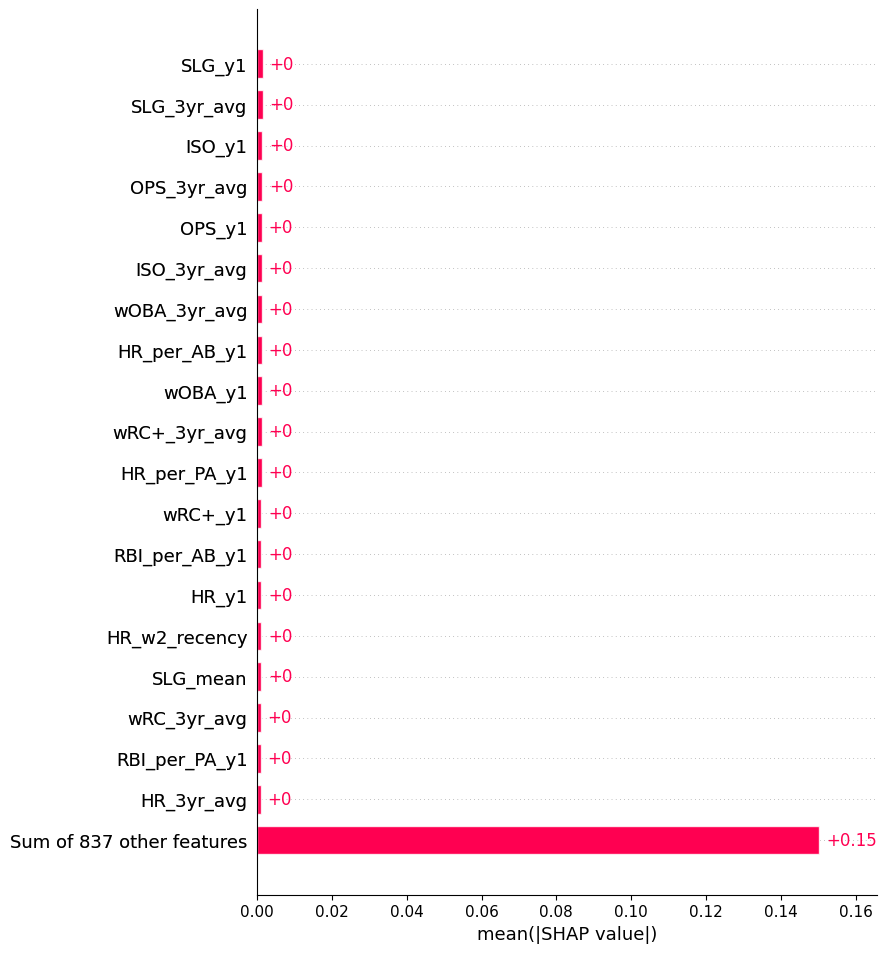

<Figure size 640x480 with 0 Axes>

In [ ]:
# SHAP analysis for best model
best_model = top5[0][0]
X_test_np = X_test.detach().numpy()

explainer = shap.Explainer(
    lambda x: best_model(torch.tensor(x, dtype=torch.float32)).detach().numpy(),
    X_test_np,
    feature_names=features
)

shap_values = explainer(X_test_np, max_evals=2000)

# Don't pass ax, just call the function directly
shap.plots.bar(shap_values, max_display=20)
plt.tight_layout()
plt.show()

In [ ]:
best_model.eval()

PlayerMLP(
  (model): Sequential(
    (0): Linear(in_features=856, out_features=512, bias=True)
    (1): Sigmoid()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): Sigmoid()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

Permutation explainer: 101it [01:04,  1.31it/s]                         


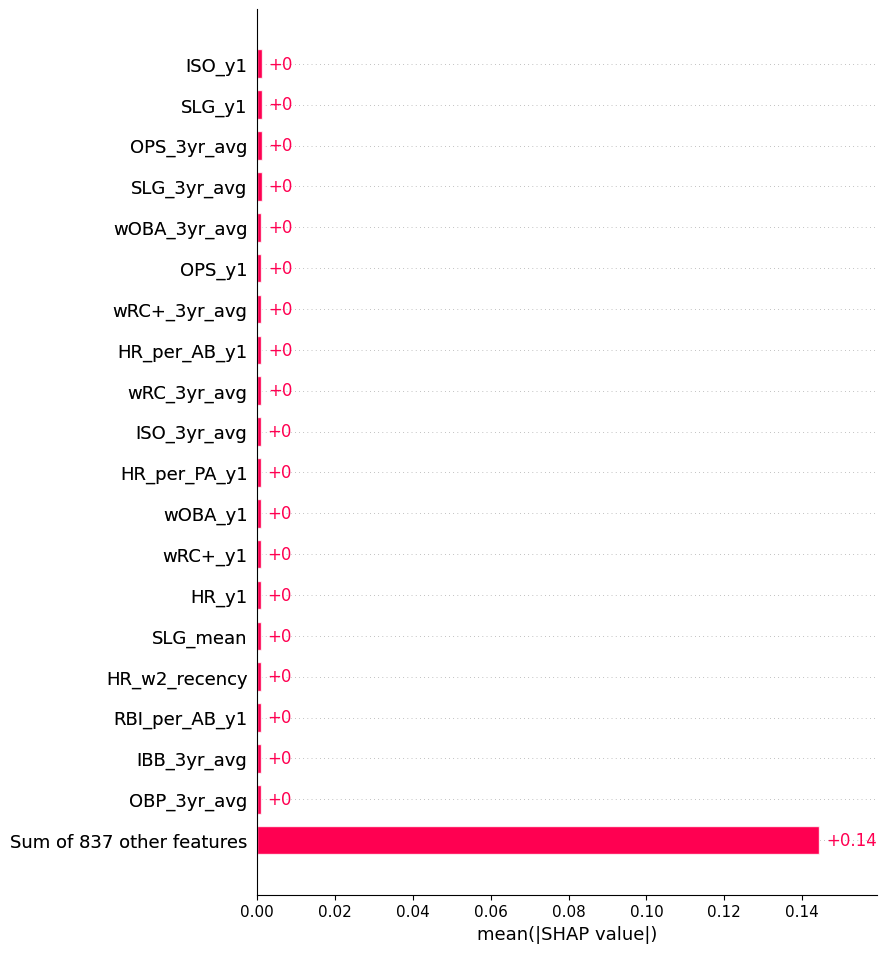

In [ ]:
sample_size = min(100, X_test_np.shape[0])
sample_idx = np.random.choice(X_test_np.shape[0], size=sample_size, replace=False)

shap_values = explainer(X_test_np[sample_idx], max_evals=2 * X_test_np.shape[1] + 1)
shap.plots.bar(shap_values, max_display=20)


In [ ]:
# SHAP analysis for best model
# Convert X_test to NumPy if it's a tensor
X_test_np = X_test.numpy()

# Create a wrapper function around your best_model to use with SHAP
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    return best_model(x_tensor).detach().numpy()

# Create SHAP explainer
explainer = shap.Explainer(model_predict, X_test_np, feature_names=features)

# Compute SHAP values
shap_values = explainer(X_test_np, max_evals=2000)


Permutation explainer: 379it [03:58,  1.52it/s]                         


In [ ]:
def get_top_shap_features(shap_values, feature_names, top_n=20):
    # Compute mean absolute SHAP value per feature
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

    # Create a DataFrame of features ranked by importance
    shap_df = pd.DataFrame({
        'Feature': feature_names,
        'MeanAbsSHAP': mean_abs_shap
    }).sort_values(by='MeanAbsSHAP', ascending=False)

    top_features = shap_df['Feature'].head(top_n).tolist()
    return top_features, shap_df


In [ ]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)


### Ensemble Learning

Aggregate predictions from the top 5 MLP models (by RMSE) to compute an ensemble prediction for the final evaluation.


In [ ]:
# Select top 5 models based on lowest RMSE
top5_results = sorted(top5, key=lambda x: x[1][2])[:5]
top5_models = [model for model, _ in top5_results]

# Get ensemble predictions by averaging outputs
with torch.no_grad():
    preds = np.stack([m(X_test).numpy().flatten() for m in top5_models], axis=1)
    ensemble_pred = preds.mean(axis=1)

# Compute final MAE and RMSE
y_true = y_test.numpy().flatten()
ensemble_mae = mean_absolute_error(y_true, ensemble_pred)
ensemble_rmse = mean_squared_error(y_true, ensemble_pred) ** 0.5

print(f"Ensemble (Top 5 Avg) → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")


Ensemble (Top 5 Avg) → MAE: 0.0574, RMSE: 0.0752


### Cross-Validation Utility (Standard MLP)

Evaluate the best hyperparameter configs using K-fold cross-validation.


In [ ]:
from sklearn.model_selection import KFold

def cross_validate_mlp(X, y, config, n_splits=5):
    hidden_dims, lr, epochs, batch_size, dropout, _, activation = config
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    maes = []
    rmses = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Fold {fold + 1}/{n_splits}")
        X_train_fold = torch.tensor(X[train_idx], dtype=torch.float32)
        y_train_fold = torch.tensor(y[train_idx], dtype=torch.float32).view(-1, 1)
        X_val_fold = torch.tensor(X[val_idx], dtype=torch.float32)
        y_val_fold = torch.tensor(y[val_idx], dtype=torch.float32).view(-1, 1)

        model = PlayerMLP(X.shape[1], hidden_dims, dropout, activation=activation).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
        loss_fn = nn.MSELoss()

        train_loader = torch.utils.data.DataLoader(
            torch.utils.data.TensorDataset(X_train_fold, y_train_fold),
            batch_size=batch_size, shuffle=True
        )

        best_loss = float("inf")
        best_model_state = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                pred = model(xb)
                loss = loss_fn(pred, yb)
                loss.backward()
                optimizer.step()

            model.eval()
            with torch.no_grad():
                X_val_fold = X_val_fold.to(device)
                y_val_fold = y_val_fold.to(device)
                val_pred = model(X_val_fold)
                val_loss = loss_fn(val_pred, y_val_fold).item()
                scheduler.step(val_loss)

            if val_loss < best_loss:
                best_loss = val_loss
                best_model_state = model.state_dict()

        if best_model_state:
            model.load_state_dict(best_model_state)

        model.eval()
        with torch.no_grad():
            y_pred = model(X_val_fold.to(device)).cpu().numpy().flatten()
            y_true = y_val_fold.cpu().numpy().flatten()
            maes.append(mean_absolute_error(y_true, y_pred))
            rmses.append(mean_squared_error(y_true, y_pred) ** 0.5)

    print(f"\nCross-Validation Results (k={n_splits}):")
    print(f"MAE:  {np.mean(maes):.4f} ± {np.std(maes):.4f}")
    print(f"RMSE: {np.mean(rmses):.4f} ± {np.std(rmses):.4f}")


In [ ]:
for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    print(f"\n Cross-validating Top-{i+1} Config: {cfg}")
    cross_validate_mlp(X_scaled, y, cfg, n_splits=5)



 Cross-validating Top-1 Config: ([512, 256], 0.0005, 500, 32, 0.2, 0.1, 'sigmoid')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0598 ± 0.0031
RMSE: 0.0770 ± 0.0043

 Cross-validating Top-2 Config: ([512, 256], 0.0005, 300, 32, 0.3, 0.1, 'sigmoid')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0599 ± 0.0030
RMSE: 0.0771 ± 0.0042

 Cross-validating Top-3 Config: ([128, 64], 0.0001, 500, 64, 0.3, 0.2, 'sigmoid')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0606 ± 0.0033
RMSE: 0.0785 ± 0.0044

 Cross-validating Top-4 Config: ([256, 128], 0.0001, 100, 128, 0.2, 0.1, 'sigmoid')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0600 ± 0.0033
RMSE: 0.0774 ± 0.0044

 Cross-validating Top-5 Config: ([128, 64], 0.0001, 300, 128, 0.2, 0.1, 'sigmoid')
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0602 ±

In [ ]:
top_features, shap_df = get_top_shap_features(shap_values, features, top_n=20)
print("\nTop 20 SHAP Features:")
for feature in top_features:
    print(feature)


Top 20 SHAP Features:
SLG_y1
SLG_3yr_avg
ISO_y1
OPS_3yr_avg
OPS_y1
ISO_3yr_avg
wOBA_3yr_avg
HR_per_AB_y1
wOBA_y1
HR_per_PA_y1
wRC+_3yr_avg
wRC+_y1
HR_y1
RBI_per_AB_y1
HR_w2_recency
SLG_mean
wRC_3yr_avg
RBI_per_PA_y1
HR_3yr_avg
wRC+_w2_recency


In [ ]:
# Get indices of top SHAP-ranked features
top_feature_indices = [features.index(f) for f in top_features]

# Convert tensors to NumPy arrays
X_train_np = X_train.numpy()
X_test_np = X_test.numpy()

# Subset to top features
X_train_reduced = X_train_np[:, top_feature_indices]
X_test_reduced = X_test_np[:, top_feature_indices]

# Optionally: rescale reduced data
scaler_reduced = StandardScaler()
X_train_reduced_scaled = scaler_reduced.fit_transform(X_train_reduced)
X_test_reduced_scaled = scaler_reduced.transform(X_test_reduced)

cross_validate_mlp(X_train_reduced_scaled, y, top5[0][1][0], n_splits=5)


Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5

Cross-Validation Results (k=5):
MAE:  0.0831 ± 0.0041
RMSE: 0.1058 ± 0.0066


In [ ]:
ensemble_preds = []
top5_models = []

for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    print(f"\n Training Top-{i+1} Config: {cfg}")
    hidden_dims, lr, epochs, batch_size, dropout, val_split, activation = cfg

    # Split again using new features
    X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42
    )

    # Convert to torch
    X_train_tensor = torch.tensor(X_train_split, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_split, dtype=torch.float32).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_split, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_split, dtype=torch.float32).view(-1, 1)

    X_train_tensor = X_train_tensor.to(device)
    y_train_tensor = y_train_tensor.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)


    model = PlayerMLP(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        dropout=dropout,
        activation=activation,
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=False)
    loss_fn = nn.MSELoss()

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size,
        shuffle=True
    )

    best_loss = float("inf")
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            optimizer.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            val_pred = model(X_test_tensor)
            val_loss = loss_fn(val_pred, y_test_tensor).item()
            scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()

    if best_model_state:
        model.load_state_dict(best_model_state)

    # Save model + predictions
    top5_models.append(model)
    with torch.no_grad():
        preds = model(X_test_tensor).cpu().numpy().flatten()
        ensemble_preds.append(preds)

# Average predictions
ensemble_preds_avg = np.mean(ensemble_preds, axis=0)
ensemble_mae = mean_absolute_error(y_test_tensor.cpu().numpy().flatten(), ensemble_preds_avg)
ensemble_rmse = mean_squared_error(y_test_tensor.cpu().numpy().flatten(), ensemble_preds_avg) ** 0.5

print(f"\n Ensemble on Engineered Features → MAE: {ensemble_mae:.4f}, RMSE: {ensemble_rmse:.4f}")



 Training Top-1 Config: ([512, 256], 0.0005, 500, 32, 0.2, 0.1, 'sigmoid')

 Training Top-2 Config: ([512, 256], 0.0005, 300, 32, 0.3, 0.1, 'sigmoid')

 Training Top-3 Config: ([128, 64], 0.0001, 500, 64, 0.3, 0.2, 'sigmoid')

 Training Top-4 Config: ([256, 128], 0.0001, 100, 128, 0.2, 0.1, 'sigmoid')

 Training Top-5 Config: ([128, 64], 0.0001, 300, 128, 0.2, 0.1, 'sigmoid')

 Ensemble on Engineered Features → MAE: 0.0575, RMSE: 0.0758


### Save Models and Metadata

Store trained models, scalers, and features on disk under `ensemble_engineered/` for reuse and prediction.


In [ ]:
import joblib
import os
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === Save Ensemble Models and Assets ===
os.makedirs("ensemble_engineered", exist_ok=True)

# Save each model
for i, model in enumerate(top5_models):
    torch.save(model.state_dict(), f"ensemble_engineered/mlp_model_{i}_{TARGET_VAR}.pt")

# Save scaler and feature names
joblib.dump(scaler, f"ensemble_engineered/scaler_{TARGET_VAR}.joblib")
joblib.dump(features, f"ensemble_engineered/features_{TARGET_VAR}.joblib")

# Also save the X_test and y_test used at ensemble training time
np.save(f"ensemble_engineered/X_test_split_{TARGET_VAR}.npy", X_test_split)
np.save(f"ensemble_engineered/y_test_split_{TARGET_VAR}.npy", y_test_split)

print("Saved ensemble models, scaler, features, and test split.")

def load_ensemble_and_predict(X_input_np):
    # Do NOT re-load and re-apply scaler — input is already scaled
    X_tensor = torch.tensor(X_input_np, dtype=torch.float32).to(device)

    # Predict with ensemble
    ensemble_preds = []
    for i in range(5):
        config = top5[i][1][0]
        hidden_dims, lr, epochs, batch_size, dropout, val_split, activation = config

        model = PlayerMLP(
            input_dim=X_tensor.shape[1],
            hidden_dims=hidden_dims,
            dropout=dropout,
            activation=activation
        ).to(device)
        model.load_state_dict(torch.load(f"ensemble_engineered/mlp_model_{i}_{TARGET_VAR}.pt"))
        model.eval()
        with torch.no_grad():
            preds = model(X_tensor).cpu().numpy().flatten()
            ensemble_preds.append(preds)

    return np.mean(ensemble_preds, axis=0)

X_test_loaded = np.load(f"ensemble_engineered/X_test_split_{TARGET_VAR}.npy")
y_test_loaded = np.load(f"ensemble_engineered/y_test_split_{TARGET_VAR}.npy")

y_pred_saved = load_ensemble_and_predict(X_test_loaded)

mae_saved = mean_absolute_error(y_test_loaded, y_pred_saved)
rmse_saved = mean_squared_error(y_test_loaded, y_pred_saved) ** 0.5

print(f"Final Ensemble Check → MAE: {mae_saved:.4f}, RMSE: {rmse_saved:.4f}")



Saved ensemble models, scaler, features, and test split.
Final Ensemble Check → MAE: 0.0575, RMSE: 0.0758


In [ ]:
print("X_train shape:", X_train_split.shape)
print("y_train shape:", y_train_split.shape)
assert not np.isnan(X_train_split).any()
assert not np.isinf(X_train_split).any()

X_train shape: (1512, 856)
y_train shape: (1512,)


### Train Tree-Based Models

Train and compare XGBoost and CatBoost regressors on the same train/test split used by the MLP models.


In [ ]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
import time

# Store results
tree_results = []

# === XGBoost ===
print("Fitting XGBoost...")
start_time = time.time()
xgb_model = XGBRegressor(
    n_estimators=50,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    n_jobs=1,          # Limit threads
    verbosity=2        # More verbose logging
)
xgb_model.fit(X_train_split, y_train_split)
y_pred_xgb = xgb_model.predict(X_test_split)
tree_results.append(("XGBoost", mean_absolute_error(y_test_split, y_pred_xgb), mean_squared_error(y_test_split, y_pred_xgb) ** 0.5))
print(f"XGBoost Training Time: {time.time() - start_time:.2f} seconds")


Fitting XGBoost...
[12:39:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:39:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:39:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:39:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:39:57] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pru

In [ ]:
# === CatBoost ===
print("Fitting CatBoost...")
start_time = time.time()
cat_model = CatBoostRegressor(iterations=50, learning_rate=0.05, depth=6, random_state=42, verbose=10, task_type="CPU")
cat_model.fit(X_train_split, y_train_split)
y_pred_cat = cat_model.predict(X_test_split)
tree_results.append(("CatBoost", mean_absolute_error(y_test_split, y_pred_cat), mean_squared_error(y_test_split, y_pred_cat) ** 0.5))
print(f"CatBoost Training Time: {time.time() - start_time:.2f} seconds")

Fitting CatBoost...
0:	learn: 0.1024972	total: 79.9ms	remaining: 3.92s
10:	learn: 0.0893048	total: 219ms	remaining: 778ms
20:	learn: 0.0819267	total: 338ms	remaining: 467ms
30:	learn: 0.0776090	total: 460ms	remaining: 282ms
40:	learn: 0.0747111	total: 585ms	remaining: 128ms
49:	learn: 0.0731442	total: 693ms	remaining: 0us
CatBoost Training Time: 1.04 seconds


In [ ]:
# === Print Results ===
print("\nTree-Based Model Comparison:")
for name, mae, rmse in tree_results:
    print(f"{name:<10} → MAE: {mae:.4f}, RMSE: {rmse:.4f}")


Tree-Based Model Comparison:
XGBoost    → MAE: 0.0632, RMSE: 0.0828
CatBoost   → MAE: 0.0609, RMSE: 0.0797


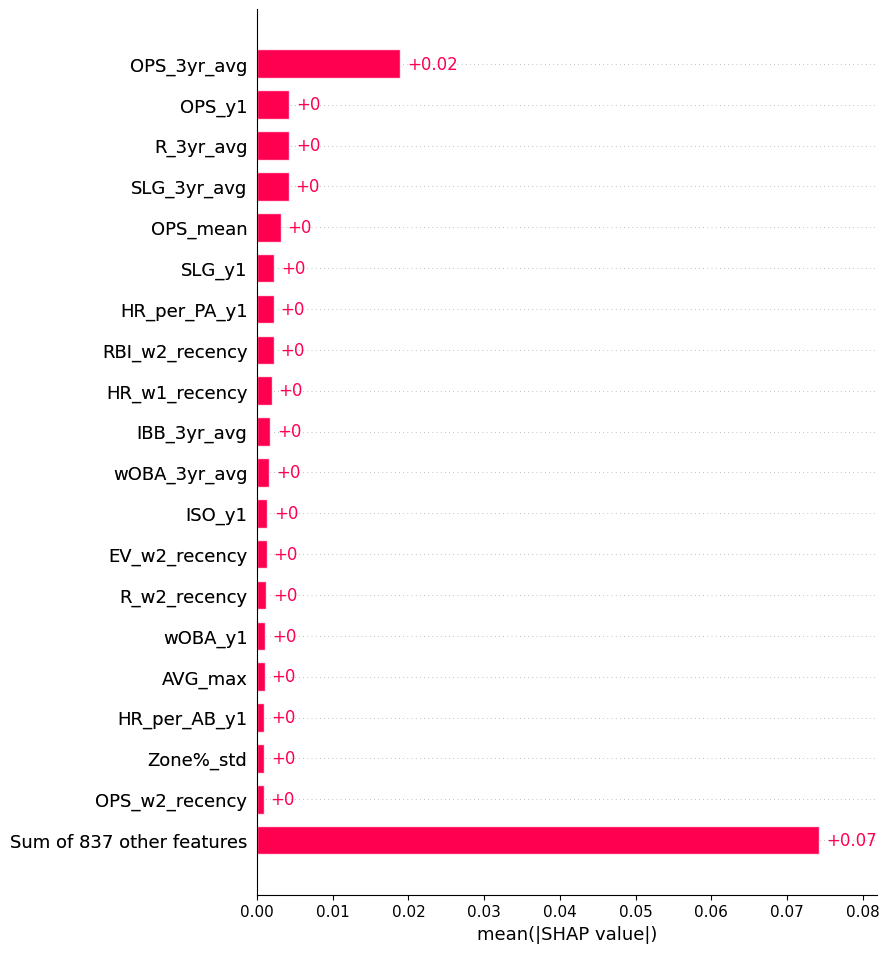

In [ ]:
X_train_df = pd.DataFrame(X_train_split, columns=features)
X_test_df = pd.DataFrame(X_test_split, columns=features)

explainer = shap.Explainer(xgb_model, X_train_df)
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20)

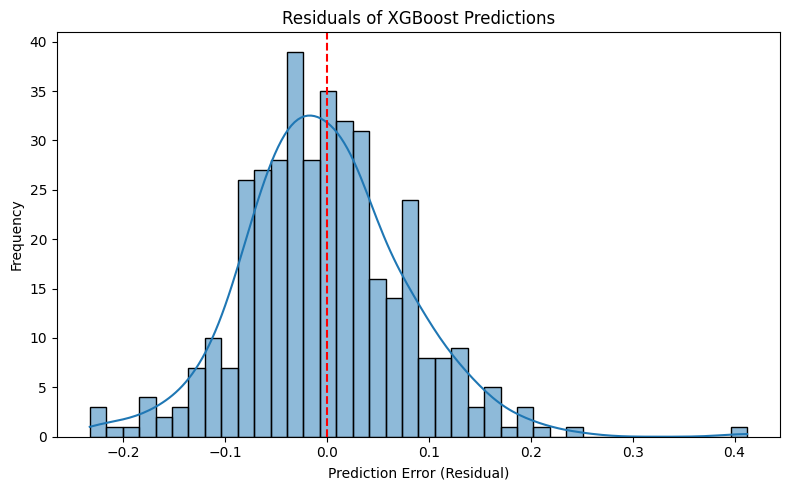

In [ ]:
import seaborn as sns

residuals = y_test_split - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of XGBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### SHAP Feature Importance for CatBoost

Use SHAP values to inspect the top features driving predictions in the CatBoost model.


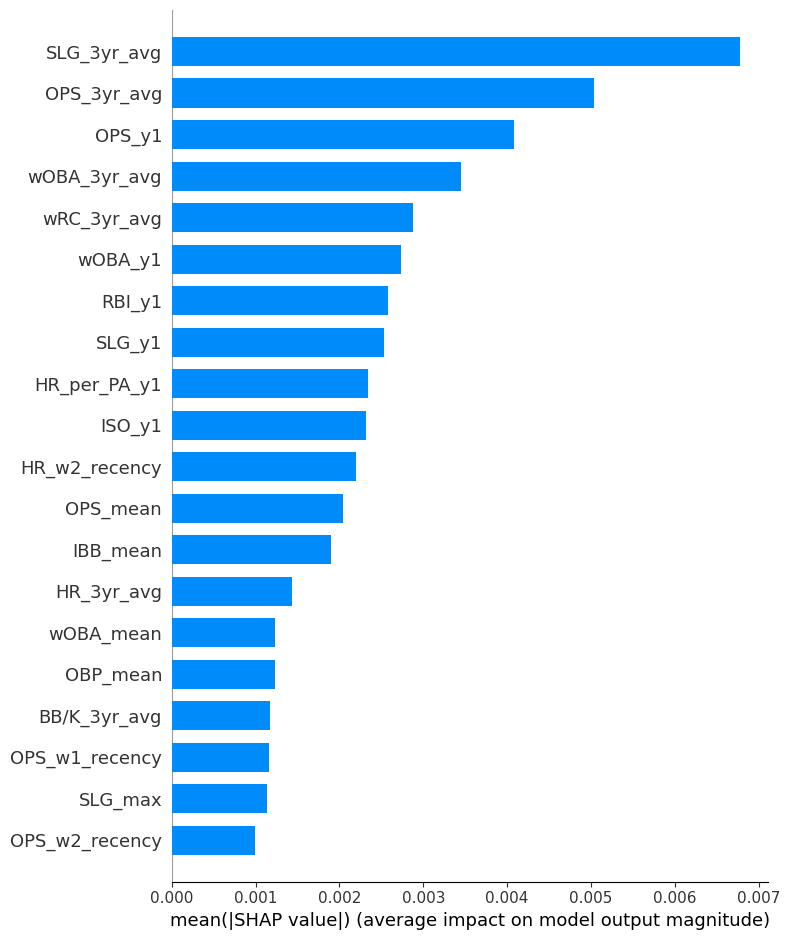

In [ ]:

# CatBoost SHAP values (last column is base value)
cat_pool = Pool(X_test_split, label=y_test_split, feature_names=features)
raw_shap_values = cat_model.get_feature_importance(type='ShapValues', data=cat_pool)
shap_values = raw_shap_values[:, :-1]  # remove base value column

# Safe and clean SHAP summary bar plot
shap.summary_plot(
    shap_values,
    X_test_split,
    feature_names=features,
    plot_type="bar"
)


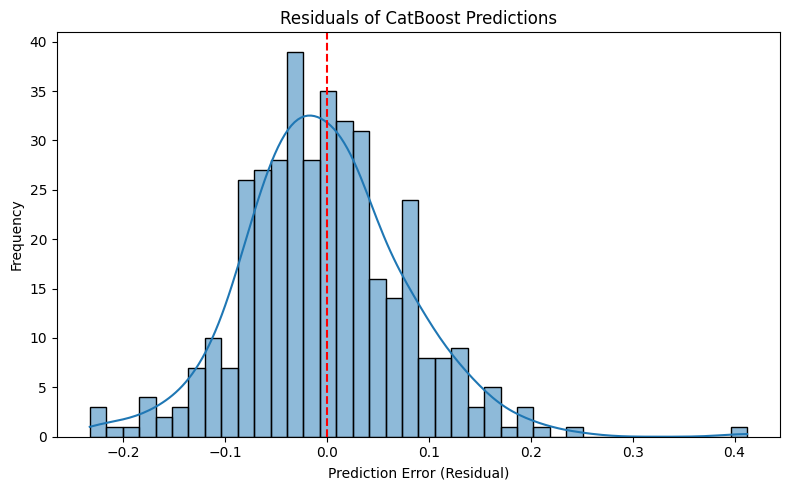

In [ ]:
import seaborn as sns

residuals = y_test_split - y_pred_cat

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True)
plt.title("Residuals of CatBoost Predictions")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()
plt.show()


### Predicting 2025 Performance

Use the trained ensemble, XGBoost, and CatBoost models to make predictions for the 2025 season based on 2024 player stats.


In [ ]:
from pybaseball import batting_stats
import pandas as pd

# Pull latest data
df_2024 = batting_stats(2024)
df_2024['Season'] = 2024

years[2024] = df_2024


# All history up to 2023
history_years = [years[y] for y in range(1900, 2024) if y in years]
df_history = pd.concat(history_years)
valid_cols = [col for col in feature_cols if col in df_history.columns]

# Rolling aggregates from 1900–2023
agg = (
    df_history
    .groupby("Name")[valid_cols]
    .agg(['mean', 'std', 'max', 'sum'])
)
agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
agg = agg.reset_index()

# Build *_y1 features
df_y1 = df_2024.copy()
y1_features = df_y1[['Name'] + [col for col in feature_cols if col in df_y1.columns]].copy()
y1_features.columns = [f"{col}_y1" if col != "Name" else "Name" for col in y1_features.columns]

# Merge historical aggregates with 2024
df_future = pd.merge(y1_features, agg, on="Name", how="inner")

if 'Team' in df_2024.columns:
    df_future['Team_recency'] = df_2024['Team']
    team_dummies = pd.get_dummies(df_future['Team_recency'], prefix='Team')
    df_future = pd.concat([df_future.drop(columns='Team_recency'), team_dummies], axis=1)


for base in ['HR', 'WAR', 'BB', 'SO', 'SB', 'CS', 'RBI', 'H']:
    if f"{base}_y1" in df_future.columns and "PA_y1" in df_future.columns:
        df_future[f"{base}_per_PA_y1"] = df_future[f"{base}_y1"] / (df_future["PA_y1"] + 1e-5)
    if f"{base}_y1" in df_future.columns and "AB_y1" in df_future.columns:
        df_future[f"{base}_per_AB_y1"] = df_future[f"{base}_y1"] / (df_future["AB_y1"] + 1e-5)


# Position encoding
if 'Pos' in df_2024.columns:
    pos_df = df_2024[['Name', 'Pos']].copy()
    pos_df['Pos'] = pos_df['Pos'].astype(str).fillna('UNK').str.split('-').str[0]
    pos_dummies = pd.get_dummies(pos_df['Pos'], prefix='Pos')
    pos_encoded = pd.concat([pos_df[['Name']], pos_dummies], axis=1)
    df_future = pd.merge(df_future, pos_encoded, on='Name', how='left')

# Add 2022, 2023, and 2024 for rolling averages
rolling_years = [years[y] for y in range(2022, 2025) if y in years]
if len(rolling_years) == 3:
    df_rolling = pd.concat(rolling_years)
    df_rolling_avg = (
        df_rolling.groupby("Name")[feature_cols]
        .mean()
        .reset_index()
    )
    df_rolling_avg.columns = ['Name'] + [f"{col}_3yr_avg" for col in df_rolling_avg.columns[1:]]
    df_future = pd.merge(df_future, df_rolling_avg, on="Name", how="left")

# Add recency-weighted features
weights = [0.6, 0.3, 0.1]
recency_years = [years.get(y) for y in range(2022, 2025) if years.get(y) is not None]
if len(recency_years) == 3:
    df_weighted = recency_years[0].copy()
    for col in feature_cols:
        if col in df_weighted.columns:
            df_weighted[col] = weights[0] * df_weighted[col]
    for i in range(1, 3):
        df_temp = recency_years[i][['Name'] + [col for col in feature_cols if col in recency_years[i].columns]].copy()
        for col in feature_cols:
            if col in df_temp.columns:
                df_temp[col] = weights[i] * df_temp[col]
        df_weighted = pd.merge(df_weighted, df_temp, on="Name", how="outer", suffixes=('', f'_w{i}'))

    df_weighted = df_weighted.fillna(0)
    weighted_sums = df_weighted.groupby("Name").sum().reset_index()
    weighted_sums.columns = ['Name'] + [f"{col}_recency" for col in weighted_sums.columns[1:]]
    df_future = pd.merge(df_future, weighted_sums, on="Name", how="left")

# Check missing columns
expected_features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
df_future_columns = set(df_future.columns)

missing_in_future = [col for col in expected_features if col not in df_future_columns]

# Fill missing expected columns with 0
for col in expected_features:
    if col not in df_future.columns:
        df_future[col] = 0

# Reorder columns to match exactly
df_future = df_future[expected_features]

# Check missing columns
expected_features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
df_future_columns = set(df_future.columns)

missing_in_future = [col for col in expected_features if col not in df_future_columns]
print(f"Missing features in 2024: {missing_in_future}")
print(" Built 2025 prediction input set:", df_future.shape)


Missing features in 2024: []
 Built 2025 prediction input set: (94, 856)


In [ ]:
features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")
print("Expected input feature count:", len(features))

Expected input feature count: 856


In [ ]:
# === Clean non-numeric feature columns for df_future ===

# 1. Clean Age Rng_recency
if 'Age Rng_recency' in df_future.columns:
    df_future['Age Rng_recency'] = (
        df_future['Age Rng_recency']
        .astype(str)
        .str.extract(r'(\d+)')
        .astype(float)
    )

# 2. Clean Dol_recency
if 'Dol_recency' in df_future.columns:
    df_future['Dol_recency'] = (
        df_future['Dol_recency']
        .astype(str)
        .str.replace(r'[^\d.\-]', '', regex=True)
        .replace('', np.nan)
        .astype(float)
    )

# 3. One-hot encode 'Team_recency' again if necessary
if 'Team_recency' in df_future.columns:
    team_dummies = pd.get_dummies(df_future['Team_recency'], prefix='Team')
    df_future = pd.concat([df_future.drop(columns='Team_recency'), team_dummies], axis=1)

# 4. Safety check: confirm all features are numeric
non_numeric = df_future.select_dtypes(include=['object']).columns.tolist()
if non_numeric:
    print("Still contains non-numeric features:", non_numeric)
    raise ValueError("Fix non-numeric columns before scaling.")


In [ ]:
# Load model assets
scaler = joblib.load(f"ensemble_engineered/scaler_{TARGET_VAR}.joblib")
features = joblib.load(f"ensemble_engineered/features_{TARGET_VAR}.joblib")

# Prepare input
df_pred = df_future.copy()
X_pred = df_pred[features].fillna(0).values
X_pred_scaled = scaler.transform(X_pred)
X_pred_tensor = torch.tensor(X_pred_scaled, dtype=torch.float32)

# Predict
ensemble_preds = []
for i, (model, (cfg, mae, rmse)) in enumerate(top5):
    model = model.to(device)
    model.eval()
    with torch.no_grad():
        preds = model(X_pred_tensor.to(device)).cpu().numpy().flatten()
        ensemble_preds.append(preds)

df_pred[f"{TARGET_VAR}_2025_pred_MLP"] = np.mean(ensemble_preds, axis=0)
print("MLP Ensemble 2025 predictions complete")


MLP Ensemble 2025 predictions complete


In [ ]:
# XGBoost (retrained without {TARGET_VAR}_y1)
xgb_model.fit(X_train_split, y_train_split)
df_pred[f"{TARGET_VAR}_2025_pred_XGBoost"] = xgb_model.predict(X_pred_scaled)

print("XGBoost 2025 predictions complete")


[12:40:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:40:04] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra nodes, 0 pruned nodes, max_depth=6
[12:40:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 62 extra nodes, 0 pruned nodes, max_depth=6
[12:40:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 60 extra nodes, 0 pruned nodes, max_depth=6
[12:40:05] INFO: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/tree/updater_prune.cc:98: tree pruning end, 54 extra 

In [ ]:
# CatBoost (retrained without {TARGET_VAR}_y1)
cat_model.fit(X_train_split, y_train_split)
df_pred[f"{TARGET_VAR}_2025_pred_CatBoost"] = cat_model.predict(X_pred_scaled)

print("CatBoost 2025 predictions complete")


0:	learn: 0.1024972	total: 19.1ms	remaining: 934ms
10:	learn: 0.0893048	total: 162ms	remaining: 575ms
20:	learn: 0.0819267	total: 311ms	remaining: 430ms
30:	learn: 0.0776090	total: 448ms	remaining: 275ms
40:	learn: 0.0747111	total: 593ms	remaining: 130ms
49:	learn: 0.0731442	total: 721ms	remaining: 0us
CatBoost 2025 predictions complete


In [ ]:
output_cols = ['Name', f"{TARGET_VAR}_2025_pred_MLP", f"{TARGET_VAR}_2025_pred_XGBoost", f"{TARGET_VAR}_2025_pred_CatBoost"]
df_pred = pd.concat([df_y1[['Name']], df_pred], axis=1)

df_pred_filtered = df_pred.dropna(subset=[f"{TARGET_VAR}_2025_pred_MLP", f"{TARGET_VAR}_2025_pred_XGBoost", f"{TARGET_VAR}_2025_pred_CatBoost"])

df_pred_filtered[output_cols].to_csv(f"../output/2025_{TARGET_VAR}_predictions.csv", index=False)
print(f"Saved 2025 predictions to output/2025_{TARGET_VAR}_predictions.csv")


Saved 2025 predictions to output/2025_OPS_predictions.csv
